In [283]:
import matplotlib
import gudhi as gd
import numpy as np
import matplotlib.pyplot as plt
import pywt
import tensorflow as tf
import pickle
import random as random
import re
import os
from PIL import Image

In [207]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


**Create data set with circles in random positions**

In [208]:
def circle(center,radius):
    circ = np.vstack([radius*np.array([np.cos(theta),np.sin(theta)]) + center for theta in np.linspace(0,2*np.pi,30)])
    return circ

#truncate where it's zero, then round to next highest power of 2
def get_trunc_ind(arr):
    for i,_ in enumerate(arr):
        if np.all(arr[i:] == np.zeros(len(arr[i:]))):
            return int(2**(np.ceil(np.log(i)/np.log(2))))
    return len(arr)

def get_len_and_pos(ind,arr):
    #assume ind > 0
    n = np.log(len(arr))/np.log(2)
    wavelength = 2**(n-int((np.log(ind)/np.log(2))))
    pos = (ind-2**(int(np.log(ind)/np.log(2))))*wavelength
    return int(wavelength),int(pos)

def get_output(max_data,all_coeffs):
    coeff,ind = max_data
    if ind == 0:
        return coeff/np.sqrt(len(all_coeffs)),len(all_coeffs),0
    else:
        wl, pos = get_len_and_pos(ind,all_coeffs)
        return coeff/np.sqrt(wl),wl,pos
    
def convert_outputs(x):
    if x == 0:
        return 0
    else:
        return np.log(x)/np.log(2)
    
def pad_and_add(x,y):
    if len(x) >= len(y):
        y = np.pad(y,(0,len(x)-len(y)),'constant',constant_values=0)
    else:
        x = np.pad(x,(0,len(y)-len(x)),'constant',constant_values=0)
    return x + y

def plot_outputs(output1,output2,output3):
    func = np.zeros(1)
    out2 = np.round(output2)
    out3 = np.round(output3)
    for i,coeff in enumerate(output1[:-1]):
        wl = 2**int(np.round(output2[i]))
        
        temppos = int(np.round(output3[i]))
        if temppos == 0:
            pos = 0
        else:
            pos = 2**temppos
        
        to_add = np.hstack([np.zeros(pos),coeff*np.ones(wl//2),(-1)*coeff*np.ones(wl//2)])
        func = pad_and_add(func,to_add)
    func += output1[-1]
    return func
    

In [209]:
try:
    with open('outputs.p','rb') as f:
        outputs = pickle.load(f)
    
    with open('inputs.p','rb') as f:
        inputs = pickle.load(f)
    
except Exception as e:
    inputs = []
    outputs = []
    for i in range(0,2000):
        centers = np.random.random(size=(10,2))
        circle_pts = np.vstack([circle(center,0.5*np.random.random()) for center in centers])
        inputs.append(circle_pts)
        rc = gd.RipsComplex(circle_pts)
        st = rc.create_simplex_tree(max_dimension=2)
        st.persistence()
        temp = st.get_filtration()
        filtrants = sorted(set({x for _,x in temp}))

        betti_data = np.array([st.persistent_betti_numbers(start,end) for start,end in zip(filtrants[:-1],filtrants[1:])])
        trunced_arr = betti_data[:get_trunc_ind(betti_data[:,1]),1]

        coeffs = pywt.wavedec(trunced_arr,wavelet='db1',level=None)
        all_coeffs = np.hstack(coeffs)
        max_inds = np.argpartition(np.abs(all_coeffs),-10)[-10:]
        sorted_max_data = [(x,y) for x,y in sorted(list(zip(all_coeffs[max_inds],max_inds)))]
        output = np.array([get_output(x,all_coeffs) for x in sorted_max_data])
        #output = output/np.max(output,axis=0)
        #output = output.flatten()
        outputs.append(output)

In [210]:
#with open('outputs.p','wb') as f:
#    pickle.dump(outputs,f)
    
#with open('inputs.p','wb') as f:
#    pickle.dump(inputs,f)

In [211]:
arr_inputs = np.array(inputs)

In [212]:
outputs1 = np.array([x[:,0] for x in outputs])
outputs2 = np.array([x[:,1] for x in outputs])
outputs3 = np.array([x[:,2] for x in outputs])

In [213]:
outputs2log = np.array([[convert_outputs(x) for x in arr] for arr in outputs2])
outputs3log = np.array([[convert_outputs(x) for x in arr] for arr in outputs3])

### Make images from inputs

In [245]:


def conv_layer(Input,activation='relu',outname='conv'):
    Conv1 = tf.keras.layers.Conv1D(64,kernel_size=3,strides=1,padding='same',input_shape=(300,2),activation=activation)(Input)
    Pooling1 = tf.keras.layers.MaxPooling1D(pool_size=2,strides=2)(Conv1)
    Conv2 = tf.keras.layers.Conv1D(64,kernel_size=3,strides=1,padding='same',activation=activation)(Pooling1)
    Pooling2 = tf.keras.layers.MaxPooling1D(pool_size=2,strides=2)(Conv2)
    Flat = tf.keras.layers.Flatten()(Pooling2)
    Dense1 = tf.keras.layers.Dense(32,activation=activation)(Flat)
    Out = tf.keras.layers.Dense(10,activation=activation,name=outname)(Dense1)
    return Out
    
def res_block_coeff(Input,activation='linear',bias_reg = None,outname='coeff'):
    Start = tf.keras.layers.Flatten()(Input)
    Dense1 = tf.keras.layers.Dense(100, activation=activation)(Start)
    #BN1 = tf.compat.v2.keras.layers.BatchNormalization()(Dense1)
    Dropout1 = tf.keras.layers.Dropout(0.2)(Dense1)
    Dense2 = tf.keras.layers.Dense(70,activation=activation)(Dropout1)
    #BN2 = tf.compat.v2.keras.layers.BatchNormalization()(Dense2)
    Dense3 = tf.keras.layers.Dense(40,activation=activation)(Dense2)
    #BN3 = tf.compat.v2.keras.layers.BatchNormalization()(Dense3)
    #Dense4 = tf.keras.layers.Dense(20,activation=activation)(BN3)
    to_add = tf.keras.layers.Dense(40,activation=activation,kernel_initializer = tf.keras.initializers.zeros())(Start)
    Add = tf.keras.layers.add([to_add,Dense3])
    Out = tf.keras.layers.Dense(10,activation = activation,bias_regularizer = bias_reg,name=outname)(Add)
    return Out

def res_block_wl(Input,activation='relu',bias_reg = None,outname='Dense'):
    Start = tf.keras.layers.Flatten()(Input)
    Dense1 = tf.keras.layers.Dense(100, activation=activation,
                                                 kernel_regularizer = tf.keras.regularizers.l2(0.01))(Start)
    BN1 = tf.compat.v2.keras.layers.BatchNormalization()(Dense1)
    Dropout1 = tf.keras.layers.Dropout(0.2)(BN1)
    Dense2 = tf.keras.layers.Dense(70,activation=activation)(Dropout1)
    #BN2 = tf.compat.v2.keras.layers.BatchNormalization()(Dense2)
    Dense3 = tf.keras.layers.Dense(40,activation=activation)(Dense2)
    #BN3 = tf.compat.v2.keras.layers.BatchNormalization()(Dense3)
    #Dense4 = tf.keras.layers.Dense(20,activation=activation)(BN3)
    #to_add = tf.keras.layers.Dense(40,activation=activation,kernel_initializer = tf.keras.initializers.Constant(1/300))(Start)
    #Add = tf.keras.layers.add([to_add,Dense3])
    Out = tf.keras.layers.Dense(10,activation = activation,bias_regularizer = bias_reg,name=outname)(Dense3)
    return Out

In [246]:
Input = tf.keras.layers.Input((300,2))

Out1 = res_block_coeff(Input,activation='linear')
Out2 = res_block_wl(Input,activation='relu',bias_reg = tf.keras.regularizers.l2(0.01),outname='wl')
Out3 = res_block_wl(Input,activation='relu',bias_reg = tf.keras.regularizers.l2(0.01),outname='pos')

model = tf.keras.Model(inputs = Input, outputs = [Out1,Out2,Out3])
#tf.keras.utils.plot_model(model,to_file='model.png')
model.compile(optimizer='adam',
              loss='mean_squared_error',
             )#metrics=['accuracy'])

In [247]:
Input_conv = tf.keras.layers.Input((300,2))

Out1_conv = conv_layer(Input_conv,activation='linear',outname='coeff')
Out2_conv = conv_layer(Input_conv,activation='relu',outname='wl')
Out3_conv = conv_layer(Input_conv,activation='relu',outname='pos')

model_conv = tf.keras.Model(inputs = Input_conv, outputs = [Out1_conv,Out2_conv,Out3_conv])
model_conv.compile(optimizer='adam',
              loss='mean_squared_error',
             )

In [248]:
logdir="logs/fit/"
!rm -r ./logs/fit
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

### Train the vanilla NN

In [249]:
model.fit(arr_inputs,[outputs1,outputs2log,outputs3log],epochs=100,callbacks=[tensorboard_callback])

Train on 2000 samples
Epoch 1/100
2000/2000 [==============================] - 2s 999us/sample - loss: 105.8891 - coeff_loss: 2.3636 - wl_loss: 72.0337 - pos_loss: 27.7387
Epoch 2/100
2000/2000 [==============================] - 0s 130us/sample - loss: 37.1859 - coeff_loss: 1.5789 - wl_loss: 19.5344 - pos_loss: 12.9837
Epoch 3/100
2000/2000 [==============================] - 0s 125us/sample - loss: 34.0532 - coeff_loss: 1.5631 - wl_loss: 17.2266 - pos_loss: 12.3087
Epoch 4/100
2000/2000 [==============================] - 0s 126us/sample - loss: 33.1739 - coeff_loss: 1.5165 - wl_loss: 16.8312 - pos_loss: 12.0742
Epoch 5/100
2000/2000 [==============================] - 0s 133us/sample - loss: 32.3333 - coeff_loss: 1.4819 - wl_loss: 16.4446 - pos_loss: 11.7443
Epoch 6/100
2000/2000 [==============================] - 0s 127us/sample - loss: 31.9101 - coeff_loss: 1.4965 - wl_loss: 16.2225 - pos_loss: 11.6645
Epoch 7/100
2000/2000 [==============================] - 0s 135us/sample - loss: 31

In [319]:
#%tensorboard --logdir logs

In [224]:
model.predict(arr_inputs[0:1,:,:])

[array([[-5.3437433 , -3.5400949 , -2.3920736 ,  0.08674717,  1.2641833 ,
          1.8221506 ,  2.3564951 ,  2.897774  ,  3.330103  ,  3.6342685 ]],
       dtype=float32),
 array([[10.330228,  0.      ,  9.088828,  9.671615, 10.885034, 10.932921,
         11.953144, 13.073652, 13.73109 , 13.870873]], dtype=float32),
 array([[ 0.      ,  0.      ,  9.319574, 10.249802,  8.247792, 10.877963,
          7.100739,  0.      ,  0.      ,  0.      ]], dtype=float32)]

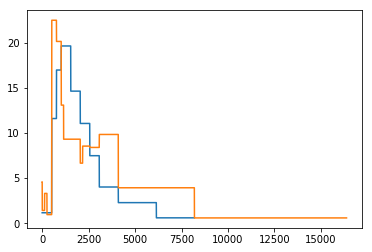

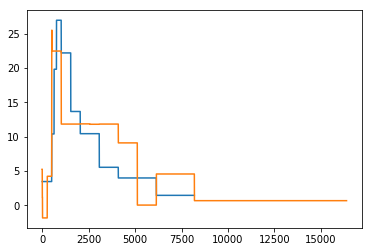

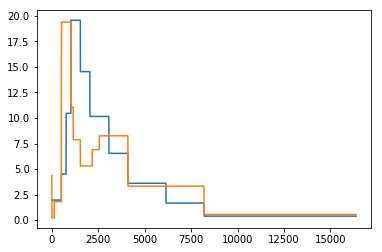

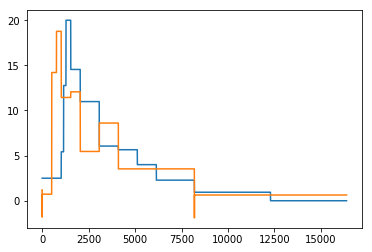

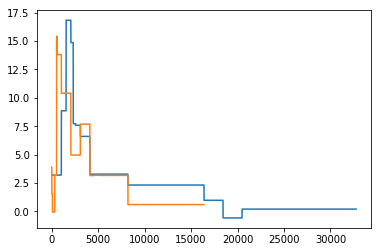

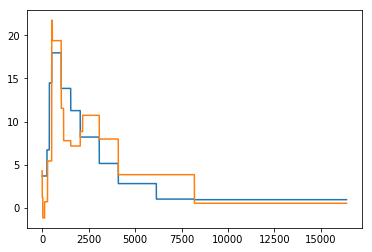

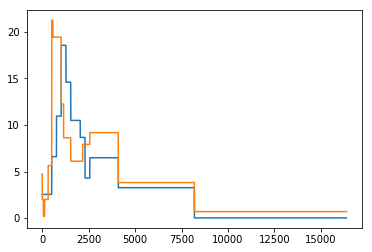

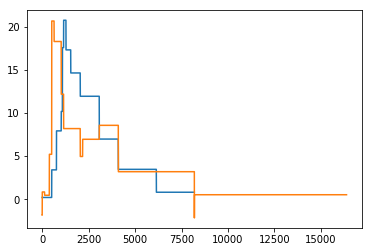

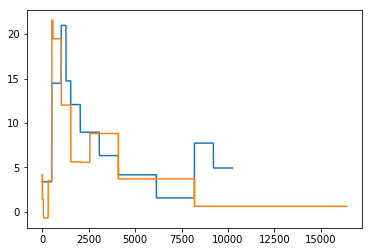

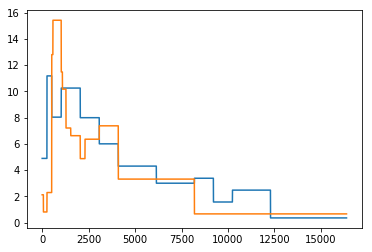

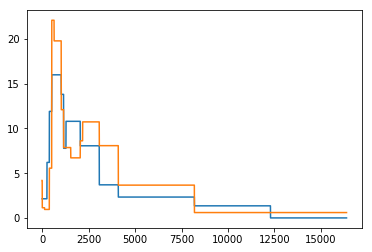

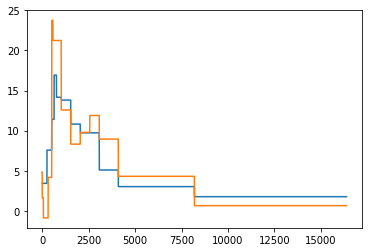

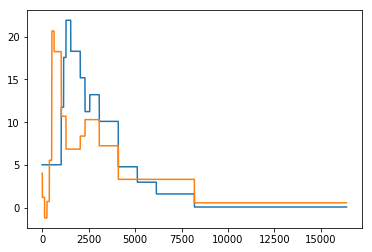

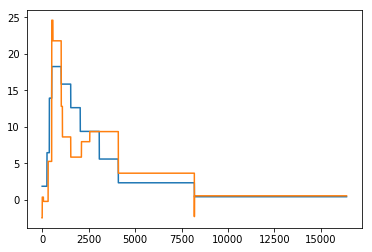

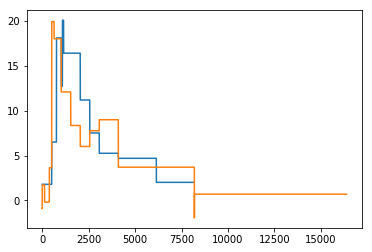

In [251]:
for i in range(0,15):
    plt.figure()
    plt.plot(plot_outputs(outputs1[i],outputs2log[i],outputs3log[i]))
    sample_input = arr_inputs[i:i+1][0].copy()
    #random.shuffle(sample_input)
    sample_input = np.expand_dims(sample_input,0)
    plt.plot(plot_outputs(*[x[0] for x in model.predict(sample_input)]))

### Train the CNN

In [252]:
model_conv.fit(arr_inputs,[outputs1,outputs2log,outputs3log],epochs=100,callbacks=[tensorboard_callback])

Train on 2000 samples
Epoch 1/100
2000/2000 [==============================] - 4s 2ms/sample - loss: 54.9684 - coeff_loss: 1.9628 - wl_loss: 27.7786 - pos_loss: 25.0804
Epoch 2/100
2000/2000 [==============================] - 3s 1ms/sample - loss: 36.9710 - coeff_loss: 1.4605 - wl_loss: 12.6669 - pos_loss: 22.8150
Epoch 3/100
2000/2000 [==============================] - 3s 1ms/sample - loss: 36.4425 - coeff_loss: 1.4445 - wl_loss: 12.2514 - pos_loss: 22.7277
Epoch 4/100
2000/2000 [==============================] - 3s 1ms/sample - loss: 36.1840 - coeff_loss: 1.4348 - wl_loss: 12.0946 - pos_loss: 22.6590
Epoch 5/100
2000/2000 [==============================] - 3s 2ms/sample - loss: 36.0498 - coeff_loss: 1.4353 - wl_loss: 12.0455 - pos_loss: 22.5758
Epoch 6/100
2000/2000 [==============================] - 3s 1ms/sample - loss: 35.9346 - coeff_loss: 1.4103 - wl_loss: 11.9961 - pos_loss: 22.5447
Epoch 7/100
2000/2000 [==============================] - 3s 2ms/sample - loss: 35.9076 - coeff_l

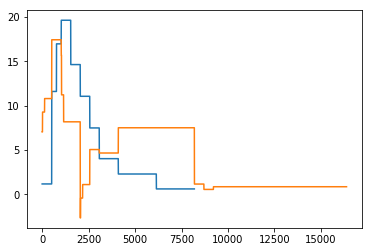

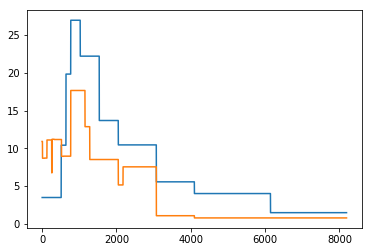

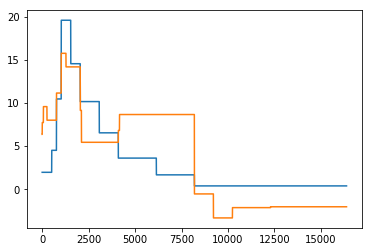

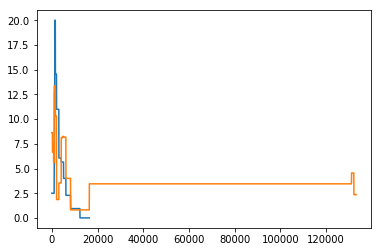

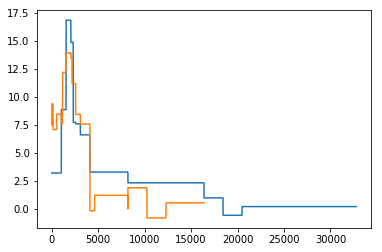

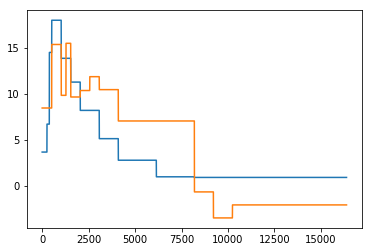

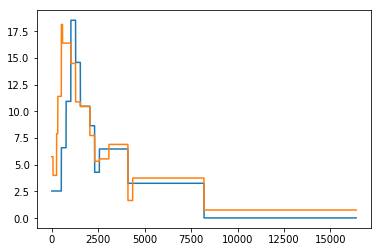

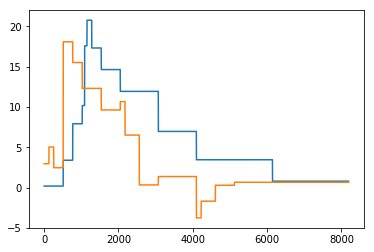

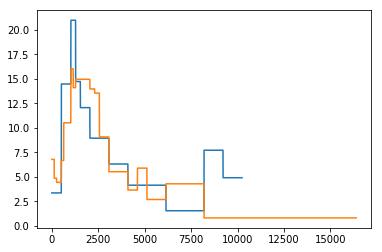

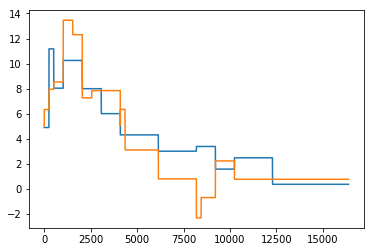

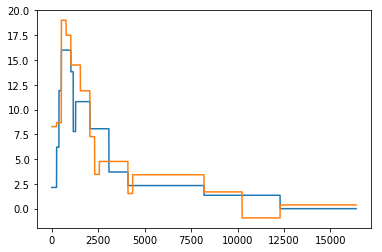

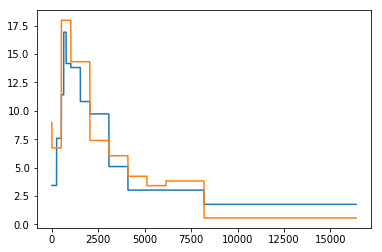

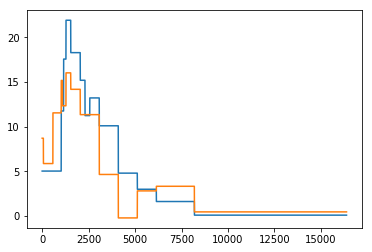

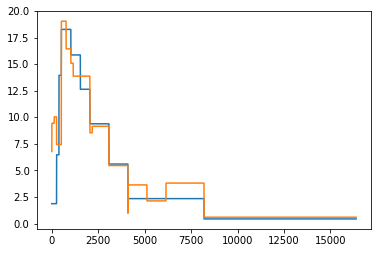

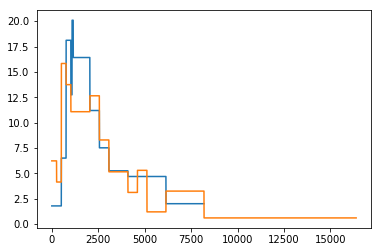

In [253]:
for i in range(0,15):
    plt.figure()
    plt.plot(plot_outputs(outputs1[i],outputs2log[i],outputs3log[i]))
    sample_input = arr_inputs[i:i+1][0].copy()
    #random.shuffle(sample_input)
    sample_input = np.expand_dims(sample_input,0)
    plt.plot(plot_outputs(*[x[0] for x in model_conv.predict(sample_input)]))

### Set up for conv2D

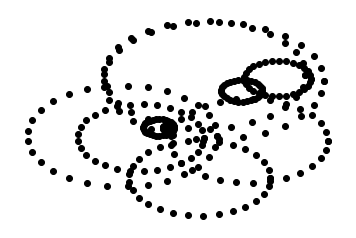

In [260]:
plt.rc('axes.spines', **{'bottom':False, 'left':False, 'right':False, 'top':False})
plt.xticks([])
plt.yticks([])
plt.scatter(inputs[16][:,0],inputs[16][:,1],color='black')

In [262]:
plt.rc('axes.spines', **{'bottom':False, 'left':False, 'right':False, 'top':False})
for i,inp in enumerate(inputs):
    plt.figure()
    plt.xticks([])
    plt.yticks([])
    plt.scatter(inp[:,0],inp[:,1],color='black')
    plt.savefig('images/points'+str(i)+'.png',bbox_inches='tight')
    plt.close()

In [271]:
def get_sort_key(filename):
    return int(re.findall(r'(\d+)',filename)[0])

In [273]:
sorted_images = sorted(os.listdir('images'),key=get_sort_key)

In [274]:
sorted_images[0]

'points0.png'

In [293]:
test = 1-np.array(Image.open('images/' + sorted_images[0]).convert('L'))/255

In [294]:
test.shape

(238, 356)

In [296]:
im_data = np.array([1-np.array(Image.open('images/' + imname).convert('L'))/255 for imname in sorted_images])

NameError: name 'im' is not defined

In [312]:
im_data = np.expand_dims(im_data,-1)
im_data.shape

(2000, 238, 356, 1)

In [313]:
def conv2_layer(Input,activation='relu',outname='conv'):
    Start = tf.keras.layers.Convolution2D(64,kernel_size=(3,3),strides=(1,1),input_shape=(238,356,1),padding='same',activation=activation)(Input)
    Pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2))(Start)
    Conv2 = tf.keras.layers.Convolution2D(64,kernel_size=(3,3),strides=(1,1),padding='same',activation=activation)(Pool1)
    Pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2))(Conv2)
    Flat = tf.keras.layers.Flatten()(Pool2)
    Out = tf.keras.layers.Dense(10,activation=activation,name=outname)(Flat)
    return Out

In [320]:
Input_conv2 = tf.keras.layers.Input((238,356,1))
Out1_conv2 = conv2_layer(Input_conv2,activation='linear',outname='coeffs')
Out2_conv2 = conv2_layer(Input_conv2,activation='relu',outname='wl')
Out3_conv2 = conv2_layer(Input_conv2,activation='relu',outname='pos')

model_conv2 = tf.keras.Model(inputs = Input_conv2, outputs = [Out1_conv2,Out2_conv2,Out3_conv2])
model_conv2.compile(optimizer='adam',
              loss='mean_squared_error',
             )

In [321]:
model_conv2.fit(im_data,[outputs1,outputs2log,outputs3log],epochs=15,callbacks=[tensorboard_callback])

Train on 2000 samples
Epoch 1/15
2000/2000 [==============================] - 611s 306ms/sample - loss: 24.1607 - coeffs_loss: 2.9226 - wl_loss: 7.2940 - pos_loss: 13.8589
Epoch 2/15
2000/2000 [==============================] - 597s 298ms/sample - loss: 14.1814 - coeffs_loss: 0.9540 - wl_loss: 1.9243 - pos_loss: 11.2958
Epoch 3/15
2000/2000 [==============================] - 582s 291ms/sample - loss: 10.3630 - coeffs_loss: 0.5163 - wl_loss: 1.0349 - pos_loss: 8.8180
Epoch 4/15
2000/2000 [==============================] - 592s 296ms/sample - loss: 6.2693 - coeffs_loss: 0.2565 - wl_loss: 0.8045 - pos_loss: 5.2041
Epoch 5/15
2000/2000 [==============================] - 591s 296ms/sample - loss: 3.8595 - coeffs_loss: 0.1143 - wl_loss: 0.6038 - pos_loss: 3.1354
Epoch 6/15
2000/2000 [==============================] - 583s 292ms/sample - loss: 2.8761 - coeffs_loss: 0.0575 - wl_loss: 0.4163 - pos_loss: 2.4061
Epoch 7/15
2000/2000 [==============================] - 597s 298ms/sample - loss: 2.4

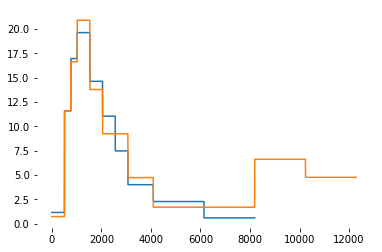

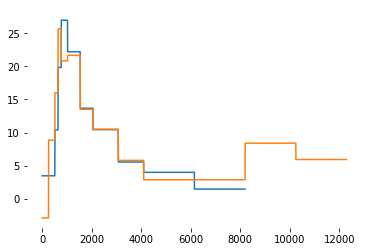

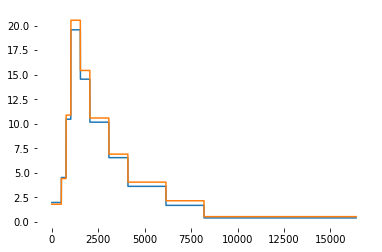

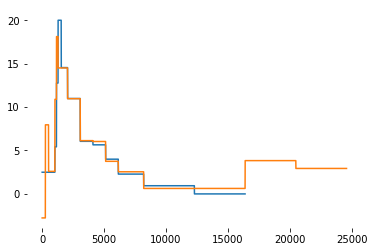

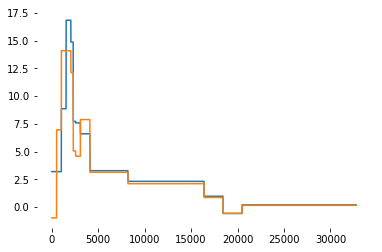

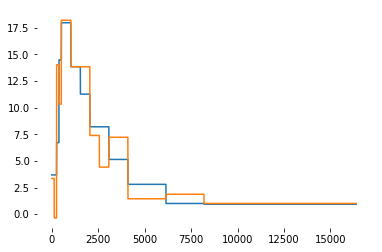

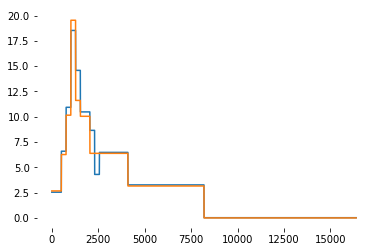

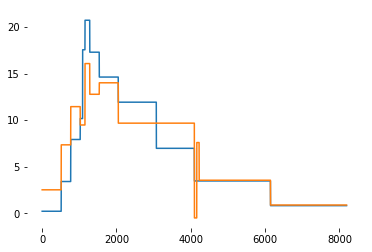

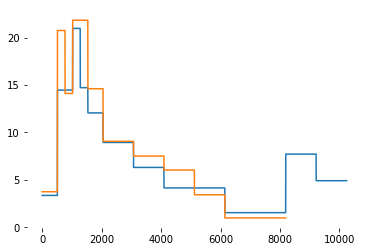

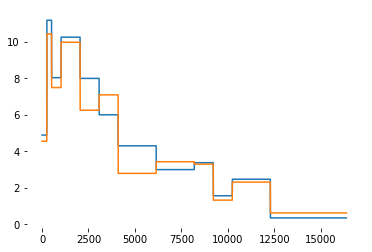

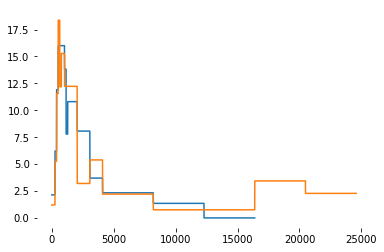

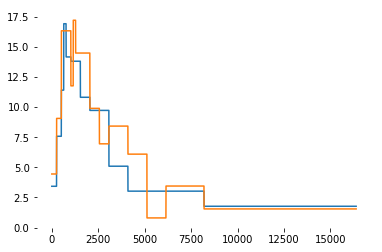

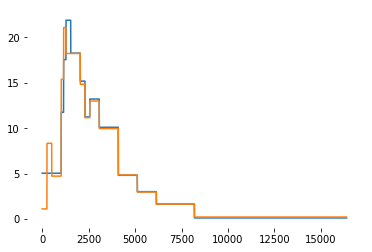

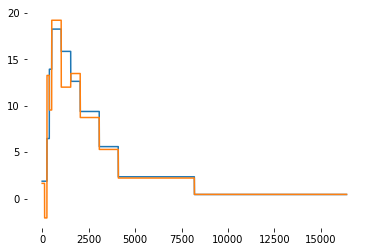

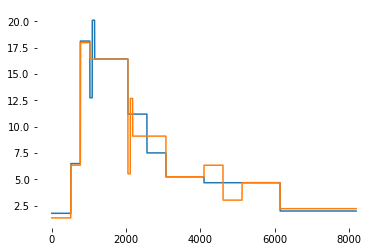

In [322]:
for i in range(0,15):
    plt.figure()
    plt.plot(plot_outputs(outputs1[i],outputs2log[i],outputs3log[i]))
    sample_input = im_data[i:i+1][0].copy()
    #random.shuffle(sample_input)
    sample_input = np.expand_dims(sample_input,0)
    plt.plot(plot_outputs(*[x[0] for x in model_conv2.predict(sample_input)]))